In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Flow matrix

In [ ]:
flows = np.array([
    [0, 10, 0,  5, 1,  0, 1, 2, 2, 2, 2, 0, 4, 0, 0],
    [10, 0, 1,  3, 2,  2, 2, 3, 2, 0, 2, 0, 10, 5, 0],
    [0, 1, 0,  10, 2, 0, 2, 5, 4, 5, 2, 2, 5, 5, 5],
    [5, 3, 10, 0, 1,  1, 5, 0, 0, 2, 1, 0, 2, 5, 0],
    [1, 2, 2,  1, 0,  3, 5, 5, 5, 1, 0, 3, 0, 5, 5],
    [0, 2, 0,  1, 3,  0, 2, 2, 1, 5, 0, 0, 2, 5, 10],
    [1, 2, 2,  5, 5,  2, 0, 6, 0, 1, 5, 5, 5, 1, 0],
    [2, 3, 5,  0, 5,  2, 6, 0, 5, 2, 10, 0, 5, 0, 0],
    [2, 2, 4,  0, 5,  1, 0, 5, 0, 0, 10, 5, 10, 0, 2],
    [2, 0, 5,  2, 1,  5, 1, 2, 0, 0, 0, 4, 0, 0, 5],
    [2, 2, 2,  1, 0,  0, 5, 10, 10, 0, 0, 5, 0, 5, 0],
    [0, 0, 2,  0, 3,  0, 5, 0, 5, 4, 5, 0, 3, 3, 0],
    [4, 10,5,  2, 0,  2, 5, 5, 10, 0, 0, 3, 0, 10,2],
    [0, 5, 5,  5, 5,  5, 1, 0, 0, 0, 5, 3, 10, 0, 4],
    [0, 0, 5,  0, 5, 10, 0, 0, 2, 5, 0, 0, 2, 4, 0],
], dtype=float)


## Locations in 5×3 grid and Manhattan distances

In [ ]:
n = 15
locations = [(i % 5, i // 5) for i in range(n)]  # (col, row)

dist = np.zeros((n, n), dtype=float)
for i in range(n):
    xi, yi = locations[i]
    for j in range(n):
        xj, yj = locations[j]
        dist[i, j] = abs(xi - xj) + abs(yi - yj)


## QAP cost for a permutation

In [ ]:
def qap_cost(perm, flows=flows, dist=dist):
    perm = np.asarray(perm, dtype=int)
    return float(np.sum(flows * dist[np.ix_(perm, perm)]) / 2.0)  # /2 because flows symmetric

## Canonical SA for QAP

In [ ]:
def sa_qap_minimize_trace(
    cost_fn,
    n=15,
    x0=None,
    T0=250.0,
    alpha_move=0.9995,     # <-- per-move cooling
    Tmin=1e-6,
    max_evals=100_000,
    seed=0,
):
    rng = np.random.default_rng(seed)

    if x0 is None:
        perm = np.arange(n)
        rng.shuffle(perm)
    else:
        perm = np.array(x0, dtype=int).copy()

    curr_cost = cost_fn(perm)
    best_perm = perm.copy()
    best_cost = curr_cost

    T = float(T0)
    evals = 1

    trace = {"eval": [], "T": [], "current_cost": [], "best_cost": [], "accepted": []}

    while T > Tmin and evals < max_evals:
        i, j = rng.choice(n, size=2, replace=False)
        new_perm = perm.copy()
        new_perm[i], new_perm[j] = new_perm[j], new_perm[i]

        new_cost = cost_fn(new_perm)
        evals += 1
        delta = new_cost - curr_cost

        accepted = 0
        if delta <= 0 or rng.random() < math.exp(-delta / T):
            perm = new_perm
            curr_cost = new_cost
            accepted = 1
            if curr_cost < best_cost:
                best_cost = curr_cost
                best_perm = perm.copy()

        trace["eval"].append(evals)
        trace["T"].append(T)
        trace["current_cost"].append(curr_cost)
        trace["best_cost"].append(best_cost)
        trace["accepted"].append(accepted)

        T *= alpha_move   # <-- key change (cool each move)

    return {"best_perm": best_perm, "best_cost": best_cost, "evals": evals,
            "final_T": T, "T0": T0, "alpha_move": alpha_move,
            "Tmin": Tmin, "max_evals": max_evals, "seed": seed, "x0": x0, "trace": trace}


## Baseline run + save CSV

In [ ]:
baseline_res = sa_qap_minimize_trace(
    cost_fn=qap_cost,
    n=15,
    x0=None,            # random start
    T0=250.0,
    alpha_move=0.995,  # Changed from alpha
    # steps_per_T=500, # Removed as it's no longer used in the updated function
    Tmin=1e-3,
    max_evals=100_000,
    seed=42
)

print("Baseline best cost:", baseline_res["best_cost"])
print("Best perm (dept->location):", baseline_res["best_perm"])

# Save summary
summary_df = pd.DataFrame([{
    "best_cost": baseline_res["best_cost"],
    "evals": baseline_res["evals"],
    "T0": baseline_res["T0"],
    "alpha_move": baseline_res["alpha_move"], # Changed from alpha
    # "steps_per_T": baseline_res["steps_per_T"], # Removed
    "Tmin": baseline_res["Tmin"],
    "max_evals": baseline_res["max_evals"],
    "seed": baseline_res["seed"],
}])
summary_df.to_csv("qap_step1_baseline_results/baseline_summary.csv", index=False)

# Save trace
trace_df = pd.DataFrame(baseline_res["trace"])
trace_df.to_csv("qap_step1_baseline_results/baseline_trace.csv", index=False)

print("Saved baseline CSVs.")

Baseline best cost: 587.0
Best perm (dept->location): [12  2  8 13  6  4 11  1  5 14  0 10  7  3  9]
Saved baseline CSVs.


## Baseline plots

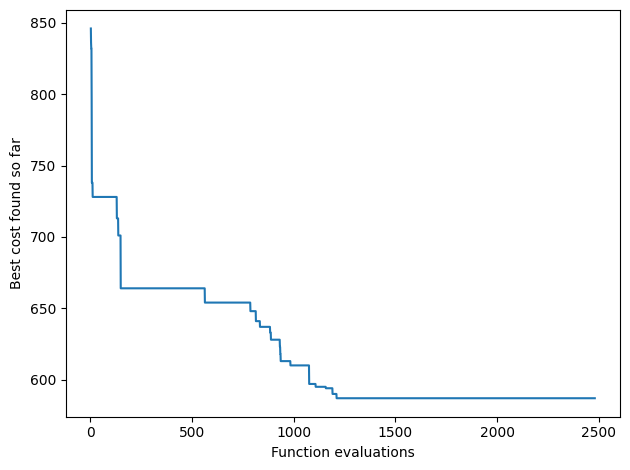

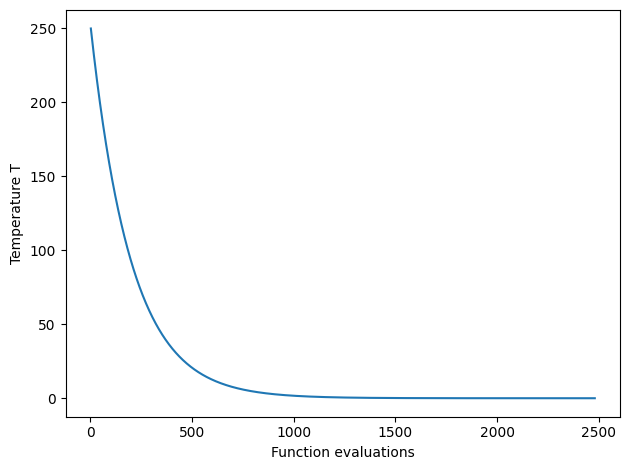

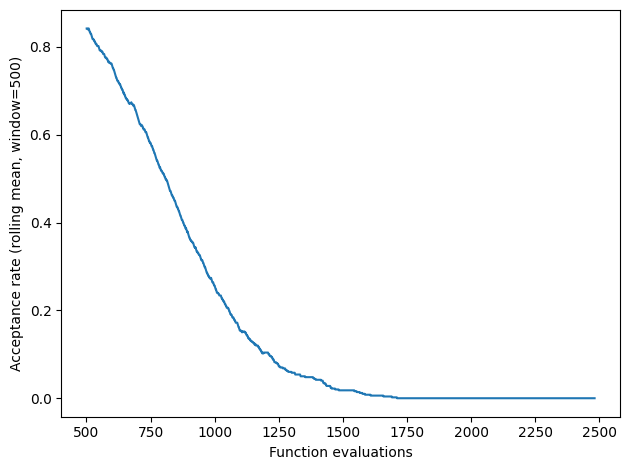

Saved baseline plots.


In [ ]:
# 1) Best cost vs evaluations
plt.figure()
plt.plot(trace_df["eval"], trace_df["best_cost"])
plt.xlabel("Function evaluations")
plt.ylabel("Best cost found so far")
plt.tight_layout()
plt.savefig("qap_step1_baseline_results/plot_best_cost_vs_evals.png", dpi=300)
plt.show()

# 2) Temperature vs evaluations
plt.figure()
plt.plot(trace_df["eval"], trace_df["T"])
plt.xlabel("Function evaluations")
plt.ylabel("Temperature T")
plt.tight_layout()
plt.savefig("qap_step1_baseline_results/plot_temperature_vs_evals.png", dpi=300)
plt.show()

# 3) Acceptance rate (rolling window)
window = 500
acc_rate = trace_df["accepted"].rolling(window).mean()
plt.figure()
plt.plot(trace_df["eval"], acc_rate)
plt.xlabel("Function evaluations")
plt.ylabel(f"Acceptance rate (rolling mean, window={window})")
plt.tight_layout()
plt.savefig("qap_step1_baseline_results/plot_acceptance_rate.png", dpi=300)
plt.show()

print("Saved baseline plots.")

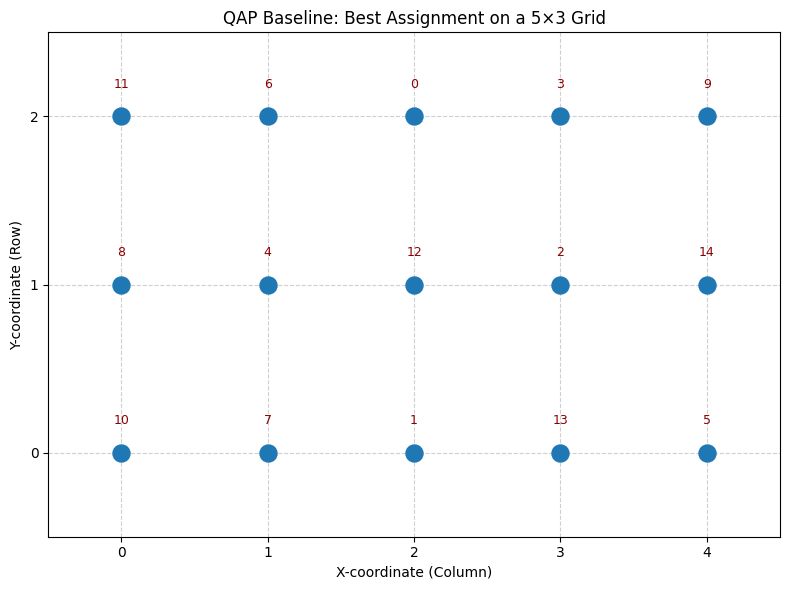

Saved: qap_step1_baseline_results/plot_baseline_assignment.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_qap_assignment(best_perm, locations, title="QAP Baseline: Department Assignment on 5×3 Grid",
                        save_path="qap_step1_baseline_results/plot_baseline_assignment.png"):
    """
    best_perm: array-like length 15, where best_perm[dept] = location_index
    locations: list of (x,y) for each location_index (0..14)
    """
    best_perm = np.asarray(best_perm, dtype=int)

    # dept -> (x,y)
    dept_coords = [locations[loc_idx] for loc_idx in best_perm]
    x_coords = [c[0] for c in dept_coords]
    y_coords = [c[1] for c in dept_coords]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, s=150, zorder=2)

    # label each point with department number
    for dept, (x, y) in enumerate(dept_coords):
        plt.text(x, y + 0.15, str(dept), ha="center", va="bottom", fontsize=9, color="darkred")

    plt.title(title)
    plt.xlabel("X-coordinate (Column)")
    plt.ylabel("Y-coordinate (Row)")

    plt.xlim(-0.5, 4.5)
    plt.ylim(-0.5, 2.5)
    plt.xticks(range(5))
    plt.yticks(range(3))
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Saved: {save_path}")

# ---- Run this after your baseline SA run ----
# baseline_res must exist from your baseline run cell
plot_qap_assignment(
    best_perm=baseline_res["best_perm"],
    locations=locations,
    title="QAP Baseline: Best Assignment on a 5×3 Grid",
    save_path="qap_step1_baseline_results/plot_baseline_assignment.png"
)


# Step 2 — 3 Annealing Schedules

In [ ]:
# 3 cooling schedules (alpha)
schedules = [
    ("Case1: alpha_0.90", 0.90),
    ("Case2: alpha_0.95", 0.95),
    ("Case3: alpha_0.98", 0.98),
]

# COMMON settings for fair comparison (keep fixed)
COMMON_S2 = dict(
    cost_fn=qap_cost,
    n=15,
    x0=None,            # baseline start (random, but fixed via seed below)
    T0=250.0,
    Tmin=1e-3,
    max_evals=100_000,
    seed=42             # fixed seed so schedules compare fairly
)

step2_summaries = []
step2_traces = {}
step2_results_for_plotting = {}

for name, alpha in schedules:
    res = sa_qap_minimize_trace(alpha_move=alpha, **COMMON_S2)

    step2_summaries.append({
        "schedule_name": name,
        "alpha_move": alpha, # Changed to alpha_move
        "best_cost": res["best_cost"],
        "evals": res["evals"],
        "final_T": res["final_T"],
        "T0": res["T0"],
        "Tmin": res["Tmin"],
        "max_evals": res["max_evals"],
        "seed": res["seed"],
    })

    step2_results_for_plotting[name] = res

    trace_df = pd.DataFrame(res["trace"])
    step2_traces[name] = trace_df
    trace_df.to_csv(f"qap_step2_annealing_schedules_results/step2_trace_{name}.csv", index=False)

# Save combined summary
step2_summary_df = pd.DataFrame(step2_summaries)
step2_summary_df.to_csv("qap_step2_annealing_schedules_results/step2_schedules_summary.csv", index=False)

step2_summary_df

,schedule_name,alpha_move,best_cost,evals,final_T,T0,Tmin,max_evals,seed
0,Case1: alpha_0.90,0.90,639.0,119,0.000997,250.0,0.001,100000,42
1,Case2: alpha_0.95,0.95,604.0,244,0.000966,250.0,0.001,100000,42
2,Case3: alpha_0.98,0.98,599.0,617,0.000984,250.0,0.001,100000,42


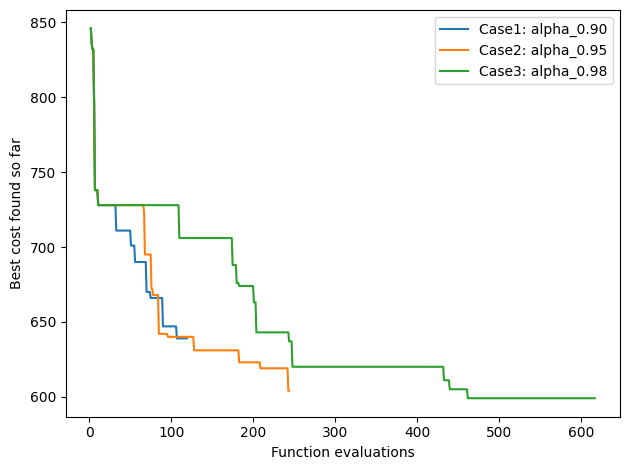

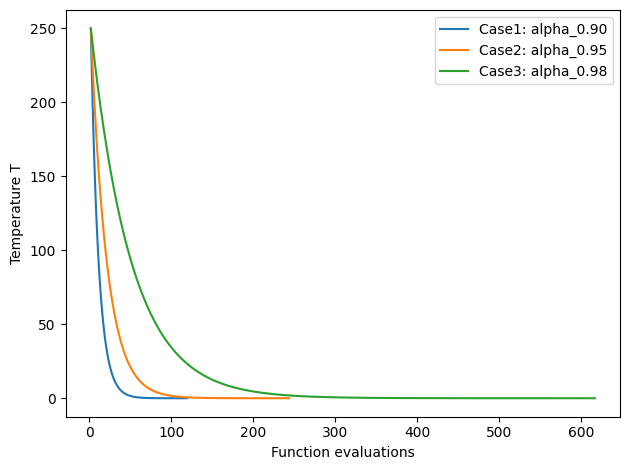

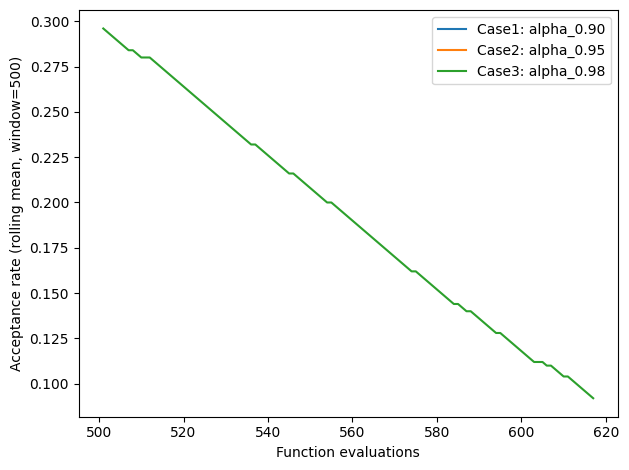

Saved Step 2:
  qap_step2_annealing_schedules_results/step2_schedules_summary.csv
  qap_step2_annealing_schedules_results/step2_best_cost_comparison.png
  qap_step2_annealing_schedules_results/step2_temperature_comparison.png
  qap_step2_annealing_schedules_results/step2_acceptance_rate_comparison.png


In [ ]:
# 1) Best cost vs evaluations (all schedules)
plt.figure()
for name, _ in schedules:
    df = step2_traces[name]
    plt.plot(df["eval"], df["best_cost"], label=name)
plt.xlabel("Function evaluations")
plt.ylabel("Best cost found so far")
plt.legend()
plt.tight_layout()
plt.savefig("qap_step2_annealing_schedules_results/step2_best_cost_comparison.png", dpi=300)
plt.show()

# 2) Temperature vs evaluations (all schedules)
plt.figure()
for name, _ in schedules:
    df = step2_traces[name]
    plt.plot(df["eval"], df["T"], label=name)
plt.xlabel("Function evaluations")
plt.ylabel("Temperature T")
plt.legend()
plt.tight_layout()
plt.savefig("qap_step2_annealing_schedules_results/step2_temperature_comparison.png", dpi=300)
plt.show()

# 3) Acceptance rate vs evaluations (rolling mean)
window = 500
plt.figure()
for name, _ in schedules:
    df = step2_traces[name]
    acc_rate = df["accepted"].rolling(window).mean()
    plt.plot(df["eval"], acc_rate, label=name)
plt.xlabel("Function evaluations")
plt.ylabel(f"Acceptance rate (rolling mean, window={window})")
plt.legend()
plt.tight_layout()
plt.savefig("qap_step2_annealing_schedules_results/step2_acceptance_rate_comparison.png", dpi=300)
plt.show()

print("Saved Step 2:")
print("  qap_step2_annealing_schedules_results/step2_schedules_summary.csv")
print("  qap_step2_annealing_schedules_results/step2_best_cost_comparison.png")
print("  qap_step2_annealing_schedules_results/step2_temperature_comparison.png")
print("  qap_step2_annealing_schedules_results/step2_acceptance_rate_comparison.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_step2_assignments(step2_results, locations,
                           save_path="qap_step2_annealing_schedules_results/plot_step2_assignments.png"):
    """
    step2_results: dict like {schedule_name: result_dict}
                   each result_dict must contain "best_perm" and "best_cost"
    locations: list of (x,y) coordinates for each location index (0..14)
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for ax, (name, res) in zip(axes, step2_results.items()):
        best_perm = np.asarray(res["best_perm"], dtype=int)
        best_cost = res["best_cost"]

        # dept -> (x,y)
        dept_coords = [locations[loc_idx] for loc_idx in best_perm]
        x_coords = [c[0] for c in dept_coords]
        y_coords = [c[1] for c in dept_coords]

        ax.scatter(x_coords, y_coords, s=150, zorder=2)

        # label each point with department number
        for dept, (x, y) in enumerate(dept_coords):
            ax.text(x, y + 0.15, str(dept),
                    ha="center", va="bottom",
                    fontsize=9, color="darkred")

        ax.set_title(f"Best Cost: {best_cost:.1f}") # Added best_cost to the title
        ax.set_xlim(-0.5, 4.5)
        ax.set_ylim(-0.5, 2.5)
        ax.set_xticks(range(5))
        ax.set_yticks(range(3))
        ax.grid(True, linestyle="--", alpha=0.6)

        ax.set_xlabel("Column")
        ax.set_ylabel("Row")

    plt.suptitle("Best Assignment under Different Cooling Schedules",
                 fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"Saved: {save_path}")

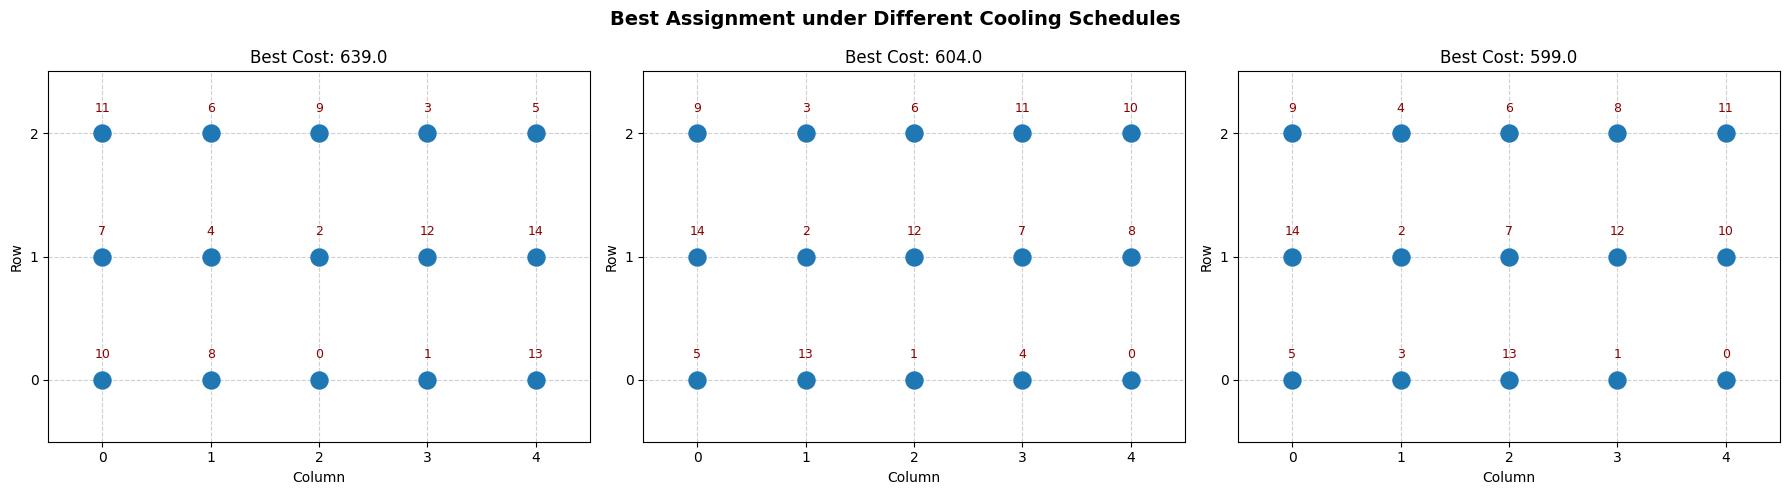

Saved: qap_step2_annealing_schedules_results/plot_step2_assignments.png


In [ ]:
plot_step2_assignments(
    step2_results=step2_results_for_plotting,
    locations=locations
)

# Step 3 — 3 Stopping Criteria

In [ ]:
stopping_rules = [
    ("Case1: Stop_Tmin_1e-3", dict(Tmin=1e-3, max_evals=100_000)),  # baseline
    ("Case2: Stop_budget_30k", dict(Tmin=0.0,  max_evals=30_000)),  # budget-limited
    ("Case3: Stop_Tmin_1e-6", dict(Tmin=1e-6, max_evals=100_000)),  # stricter Tmin
]

# COMMON settings for fair stopping comparison (keep fixed)
COMMON_S3 = dict(
    cost_fn=qap_cost,
    n=15,
    x0=None,            # fixed via seed
    T0=250.0,
    alpha_move=0.995, # Changed from alpha
    seed=42
)

step3_summaries = []
step3_traces = {}
step3_results_for_plotting = {}

for name, stop_kwargs in stopping_rules:
    res = sa_qap_minimize_trace(**COMMON_S3, **stop_kwargs)

    step3_summaries.append({
        "stop_name": name,
        "Tmin": stop_kwargs["Tmin"],
        "max_evals": stop_kwargs["max_evals"],
        "best_cost": res["best_cost"],
        "evals": res["evals"],
        "final_T": res["final_T"],
        "T0": res["T0"],
        "alpha_move": res["alpha_move"], # Changed from alpha
        "Tmin": res["Tmin"],
        "max_evals": res["max_evals"],
        "seed": res["seed"],
    })

    step3_results_for_plotting[name] = res

    trace_df = pd.DataFrame(res["trace"])
    step3_traces[name] = trace_df
    trace_df.to_csv(f"qap_step3_stopping_criteria_results/step3_trace_{name}.csv", index=False)

step3_summary_df = pd.DataFrame(step3_summaries)
step3_summary_df.to_csv("qap_step3_stopping_criteria_results/step3_stopping_summary.csv", index=False)

step3_summary_df

,stop_name,Tmin,max_evals,best_cost,evals,final_T,T0,alpha_move,seed
0,Case1: Stop_Tmin_1e-3,0.001000,100000,587.0,2481,9.981143e-04,250.0,0.995,42
1,Case2: Stop_budget_30k,0.000000,30000,587.0,30000,1.237483e-63,250.0,0.995,42
2,Case3: Stop_Tmin_1e-6,0.000001,100000,587.0,3859,9.985861e-07,250.0,0.995,42


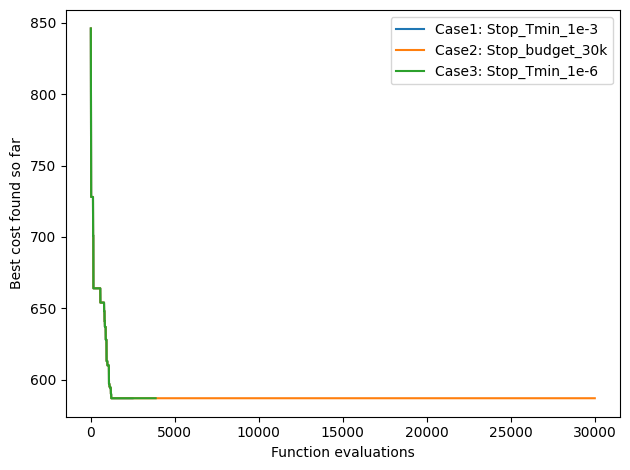

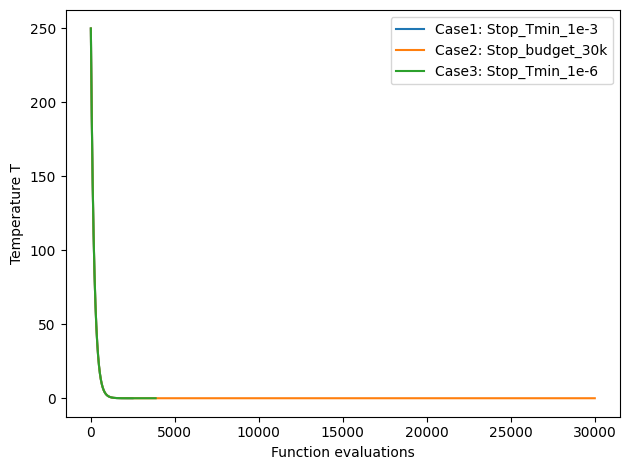

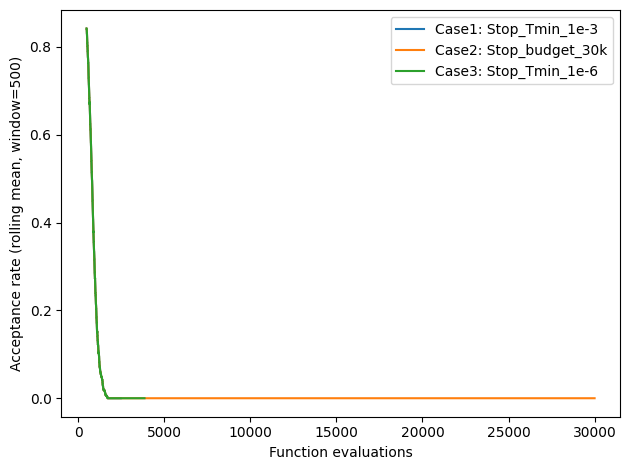

Saved Step 3:
  qap_step3_stopping_criteria_results/step3_stopping_summary.csv
  qap_step3_stopping_criteria_results/step3_best_cost_comparison.png
  qap_step3_stopping_criteria_results/step3_temperature_comparison.png
  qap_step3_stopping_criteria_results/step3_acceptance_rate_comparison.png


In [ ]:
# Step 3 plots (QAP)

# 1) Best cost vs evaluations
plt.figure()
for name, _ in stopping_rules:
    df = step3_traces[name]
    plt.plot(df["eval"], df["best_cost"], label=name)
plt.xlabel("Function evaluations")
plt.ylabel("Best cost found so far")
plt.legend()
plt.tight_layout()
plt.savefig("qap_step3_stopping_criteria_results/step3_best_cost_comparison.png", dpi=300)
plt.show()

# 2) Temperature vs evaluations
plt.figure()
for name, _ in stopping_rules:
    df = step3_traces[name]
    plt.plot(df["eval"], df["T"], label=name)
plt.xlabel("Function evaluations")
plt.ylabel("Temperature T")
plt.legend()
plt.tight_layout()
plt.savefig("qap_step3_stopping_criteria_results/step3_temperature_comparison.png", dpi=300)
plt.show()

# 3) Acceptance rate vs evaluations (rolling mean)
window = 500
plt.figure()
for name, _ in stopping_rules:
    df = step3_traces[name]
    acc_rate = df["accepted"].rolling(window).mean()
    plt.plot(df["eval"], acc_rate, label=name)
plt.xlabel("Function evaluations")
plt.ylabel(f"Acceptance rate (rolling mean, window={window})")
plt.legend()
plt.tight_layout()
plt.savefig("qap_step3_stopping_criteria_results/step3_acceptance_rate_comparison.png", dpi=300)
plt.show()

print("Saved Step 3:")
print("  qap_step3_stopping_criteria_results/step3_stopping_summary.csv")
print("  qap_step3_stopping_criteria_results/step3_best_cost_comparison.png")
print("  qap_step3_stopping_criteria_results/step3_temperature_comparison.png")
print("  qap_step3_stopping_criteria_results/step3_acceptance_rate_comparison.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_step3_assignments(step3_results, locations,
                           save_path="qap_step3_stopping_criteria_results/plot_step3_assignments.png"):
    """
    step3_results: dict like {stop_name: result_dict}
                   each result_dict must contain "best_perm" and "best_cost"
    locations: list of (x,y) coordinates
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for ax, (name, res) in zip(axes, step3_results.items()):

        best_perm = np.asarray(res["best_perm"], dtype=int)
        best_cost = res["best_cost"]

        dept_coords = [locations[loc_idx] for loc_idx in best_perm]
        x_coords = [c[0] for c in dept_coords]
        y_coords = [c[1] for c in dept_coords]

        ax.scatter(x_coords, y_coords, s=150, zorder=2)

        for dept, (x, y) in enumerate(dept_coords):
            ax.text(x, y + 0.15, str(dept),
                    ha="center", va="bottom",
                    fontsize=9, color="darkred")

        ax.set_title(f"Best Cost: {best_cost:.1f}")
        ax.set_xlim(-0.5, 4.5)
        ax.set_ylim(-0.5, 2.5)
        ax.set_xticks(range(5))
        ax.set_yticks(range(3))
        ax.grid(True, linestyle="--", alpha=0.6)

        ax.set_xlabel("Column")
        ax.set_ylabel("Row")

    plt.suptitle("Best Assignment under Different Stopping Criteria",
                 fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"Saved: {save_path}")

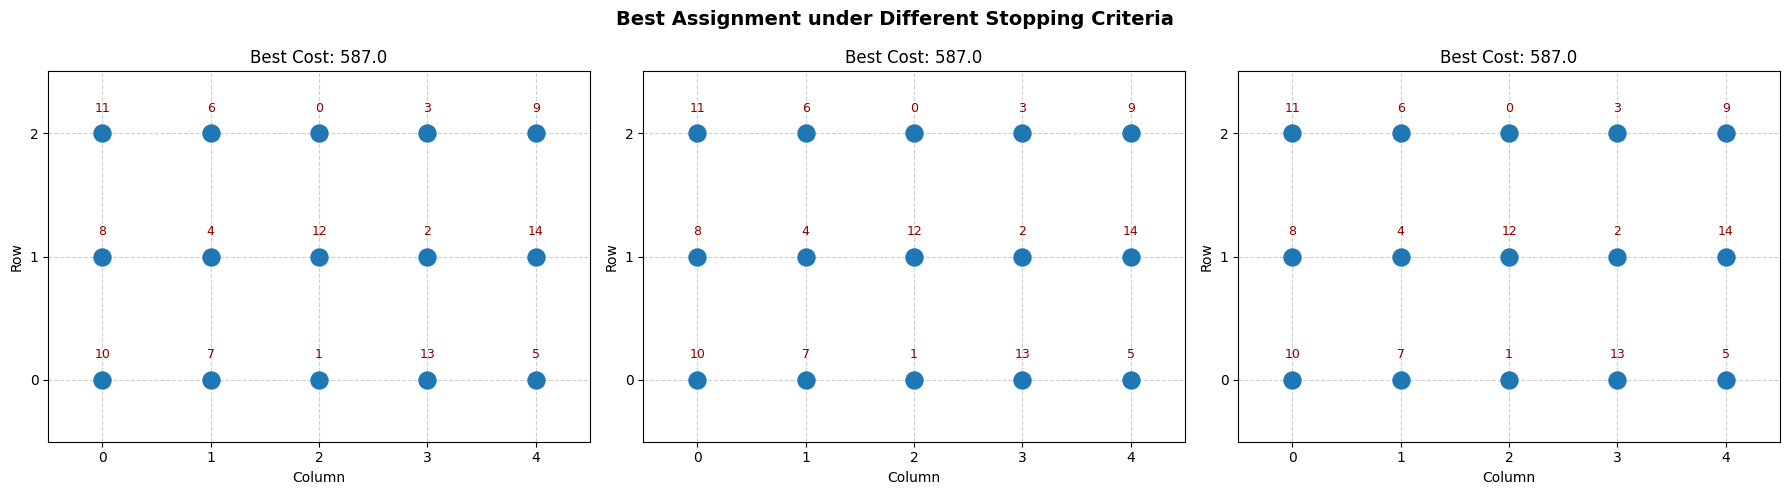

Saved: qap_step3_stopping_criteria_results/plot_step3_assignments.png


In [ ]:
plot_step3_assignments(
    step3_results=step3_results_for_plotting,
    locations=locations
)

# Step 4 — 45 Runs (3 schedules × 3 stopping × 5 random starts)

In [ ]:
def make_random_perm(n, seed):
    rng = np.random.default_rng(seed)
    perm = np.arange(n)
    rng.shuffle(perm)
    return perm

# 5 random starting permutations
start_seeds = [101, 202, 303, 404, 505]
starts = []
for i, s in enumerate(start_seeds, start=1):
    starts.append((f"Start{i}: seed_{s}", make_random_perm(15, s)))

# Fixed shared params (keep constant for fairness)
COMMON_45 = dict(
    cost_fn=qap_cost,
    n=15,
    T0=250.0,

)

rows = []
run_id = 0

for sched_name, alpha in schedules:
    for stop_name, stop_kwargs in stopping_rules:
        for start_name, x0_perm in starts:
            run_id += 1
            seed = 3000 + run_id  # unique seed per run (move randomness)

            res = sa_qap_minimize_trace(
                **COMMON_45,
                alpha_move=alpha, # Changed from alpha
                x0=x0_perm,
                seed=seed,
                **stop_kwargs
            )

            rows.append({
                "run_id": run_id,
                "schedule": sched_name,
                "alpha_move": alpha, # Changed from alpha
                "stopping": stop_name,
                "Tmin": stop_kwargs["Tmin"],
                "max_evals": stop_kwargs["max_evals"],
                "start": start_name,
                "start_seed": int(start_name.split("_")[-1]),
                "best_cost": res["best_cost"],
                "evals": res["evals"],
                "final_T": res["final_T"],
                "seed": seed,
                "best_perm": res["best_perm"]
            })

summary_45_df = pd.DataFrame(rows)
summary_45_df.to_csv("qap_step4_combined_results/step4_45runs_summary.csv", index=False)

summary_45_df.head()

,run_id,schedule,alpha_move,stopping,Tmin,max_evals,start,start_seed,best_cost,evals,final_T,seed,best_perm
0,1,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,Start1: seed_101,101,665.0,119,0.000997,3001,"[14, 9, 2, 4, 10, 13, 5, 11, 12, 3, 0, 1, 7, 6..."
1,2,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,Start2: seed_202,202,587.0,119,0.000997,3002,"[4, 3, 7, 9, 11, 13, 6, 1, 5, 14, 0, 10, 2, 8,..."
2,3,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,Start3: seed_303,303,617.0,119,0.000997,3003,"[14, 12, 8, 13, 2, 4, 11, 10, 1, 9, 0, 5, 6, 7..."
3,4,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,Start4: seed_404,404,612.0,119,0.000997,3004,"[10, 11, 7, 5, 8, 1, 13, 14, 9, 0, 4, 3, 12, 2..."
4,5,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,Start5: seed_505,505,645.0,119,0.000997,3005,"[5, 7, 11, 10, 2, 3, 13, 4, 8, 0, 9, 14, 6, 12..."


/tmp/ipython-input-3442124921.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=combos, vert=True)


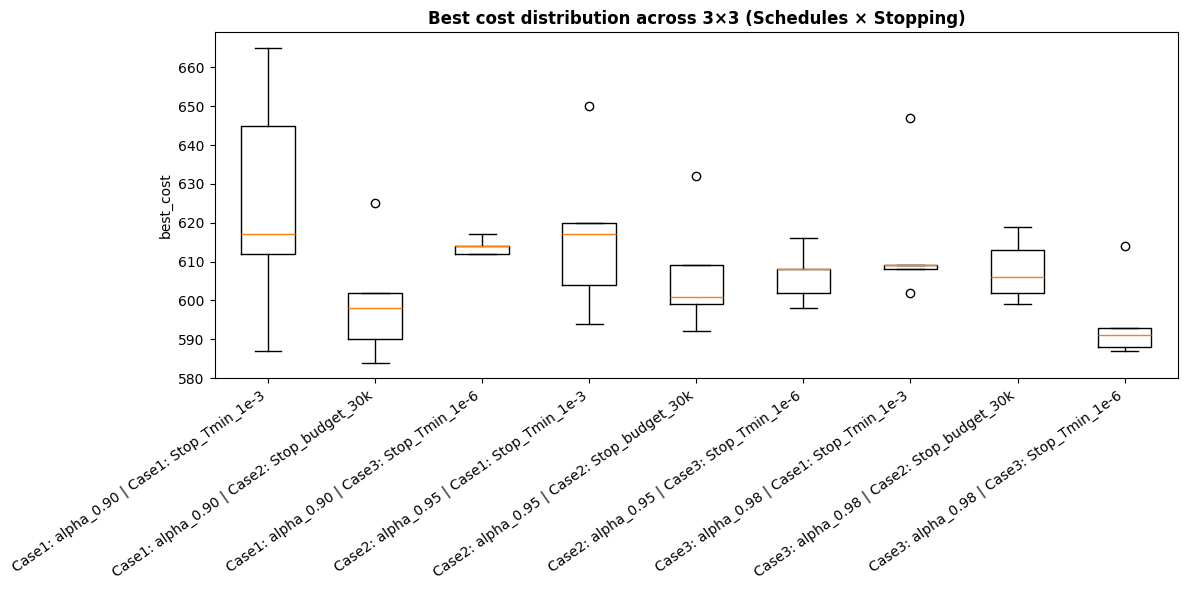

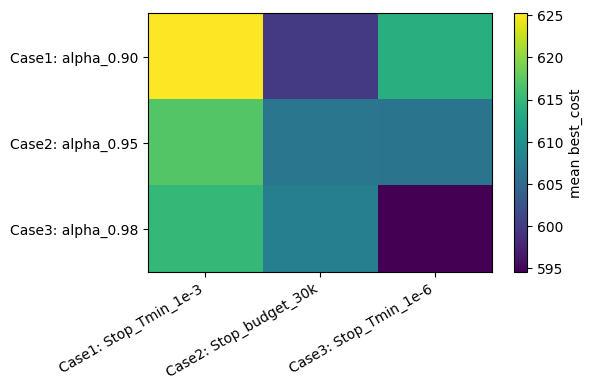

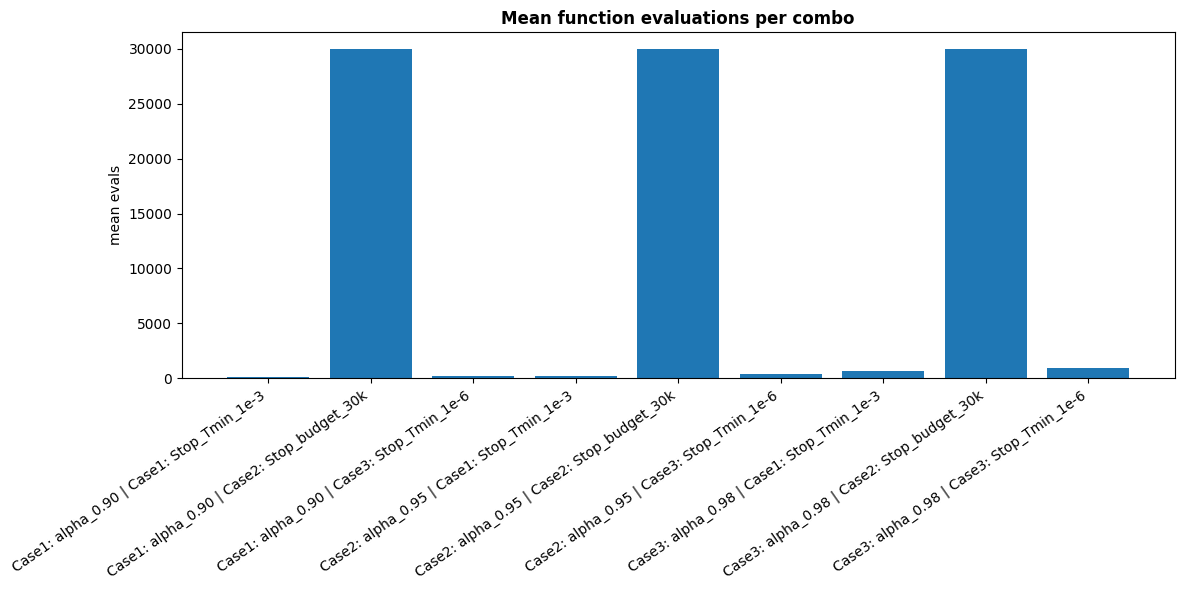

Saved Step 4:
  qap_step4_combined_results/step4_45runs_summary.csv
  qap_step4_combined_results/step4_boxplot_best_cost.png
  qap_step4_combined_results/step4_heatmap_mean_best_cost.png
  qap_step4_combined_results/step4_bar_mean_evals.png


In [ ]:
# boxplot + heatmap + mean evals bar
df = summary_45_df.copy()
df["combo"] = df["schedule"] + " | " + df["stopping"]

# 1) Boxplot: best_cost distribution per combo
combos = sorted(df["combo"].unique())
data = [df.loc[df["combo"] == c, "best_cost"].values for c in combos]

plt.figure(figsize=(12, 6))
plt.boxplot(data, labels=combos, vert=True)
plt.xticks(rotation=35, ha="right")
plt.ylabel("best_cost")
plt.title("Best cost distribution across 3×3 (Schedules × Stopping)", fontweight='bold')
plt.tight_layout()
plt.savefig("qap_step4_combined_results/step4_boxplot_best_cost.png", dpi=300)
plt.show()

# 2) Heatmap: mean best_cost for each schedule × stopping
pivot_mean = df.pivot_table(index="schedule", columns="stopping", values="best_cost", aggfunc="mean")
plt.figure(figsize=(6, 4))
plt.imshow(pivot_mean.values, aspect="auto")
plt.xticks(range(pivot_mean.shape[1]), pivot_mean.columns, rotation=30, ha="right")
plt.yticks(range(pivot_mean.shape[0]), pivot_mean.index)
plt.colorbar(label="mean best_cost")
plt.tight_layout()
plt.savefig("qap_step4_combined_results/step4_heatmap_mean_best_cost.png", dpi=300)
plt.show()

# 3) Bar plot: mean evals per combo
mean_evals = df.groupby("combo")["evals"].mean().reindex(combos)
plt.figure(figsize=(12, 6))
plt.bar(mean_evals.index, mean_evals.values)
plt.xticks(rotation=35, ha="right")
plt.ylabel("mean evals")
plt.title("Mean function evaluations per combo", fontweight='bold')
plt.tight_layout()
plt.savefig("qap_step4_combined_results/step4_bar_mean_evals.png", dpi=300)
plt.show()

print("Saved Step 4:")
print("  qap_step4_combined_results/step4_45runs_summary.csv")
print("  qap_step4_combined_results/step4_boxplot_best_cost.png")
print("  qap_step4_combined_results/step4_heatmap_mean_best_cost.png")
print("  qap_step4_combined_results/step4_bar_mean_evals.png")
